In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

from quantum_error_correction_code import surface_code
from neural_network import CNNDual

from environmentPML import Environment

import jax.numpy as jnp
from jax import random
import pickle
from time import time

key = random.key(32)

In [2]:
with open("../trained_decoders/CNNDecoder.pkl", "rb") as file:
    (
        CODE_DISTANCE,
        CONV_LAYERS,
        FC_LAYERS,
        DEFORMATION_OPTIONS,
        ERROR_PROBS,
        model_params,
    ) = pickle.load(file)

print(f"{CODE_DISTANCE = }")
print(f"{DEFORMATION_OPTIONS = }")
print(f"{ERROR_PROBS = }")
print(f"{CONV_LAYERS = }")
print(f"{FC_LAYERS = }")

CODE_DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)

CODE_DISTANCE = 3
DEFORMATION_OPTIONS = Array([0, 1, 2, 3, 4, 5], dtype=int32)
ERROR_PROBS = Array([9.98004e-06, 9.98004e-06, 9.98004e-03], dtype=float32)
CONV_LAYERS = [(3, 2, 1), (20, 2, 1)]
FC_LAYERS = [40, 2]


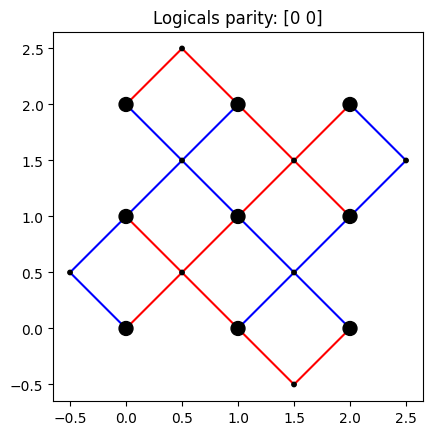

In [3]:
code = surface_code(CODE_DISTANCE)
parity_info = code.deformation_parity_info(CODE_DEFORMATION)
code.show(parity_info)

In [4]:
model = CNNDual(
    input_shape_primary=(1, CODE_DISTANCE+1, CODE_DISTANCE+1), 
    input_shape_secondary=(DEFORMATION_OPTIONS.shape[0], CODE_DISTANCE, CODE_DISTANCE), 
    conv_layers=CONV_LAYERS, 
    fc_layers=FC_LAYERS
)

In [5]:
env = Environment(
    noise_model=ERROR_PROBS,
    code=code,
)

In [ ]:
env._score_state(key, jnp.array([3, 2, 1, 2, 2, 3, 2, 0, 2]))[0] # = 401.46786

Array(401.46786, dtype=float32)

In [11]:
state, score, key = env.reset(key)

In [12]:
time_limit = 10
sample_count = 0
t0 = time()
while time() - t0 < time_limit:
    state, score, key = env.reset(key)
    sample_count = sample_count + 1
print(f"Average execution time = {(time()-t0)/sample_count:.3f}s per exact estimate ({sample_count} samples)")

Average execution time = 0.000s per exact estimate (104664 samples)


In [13]:
scores = []
for i in range(100):
    state, score, key = env.reset(key)
    scores.append(score)

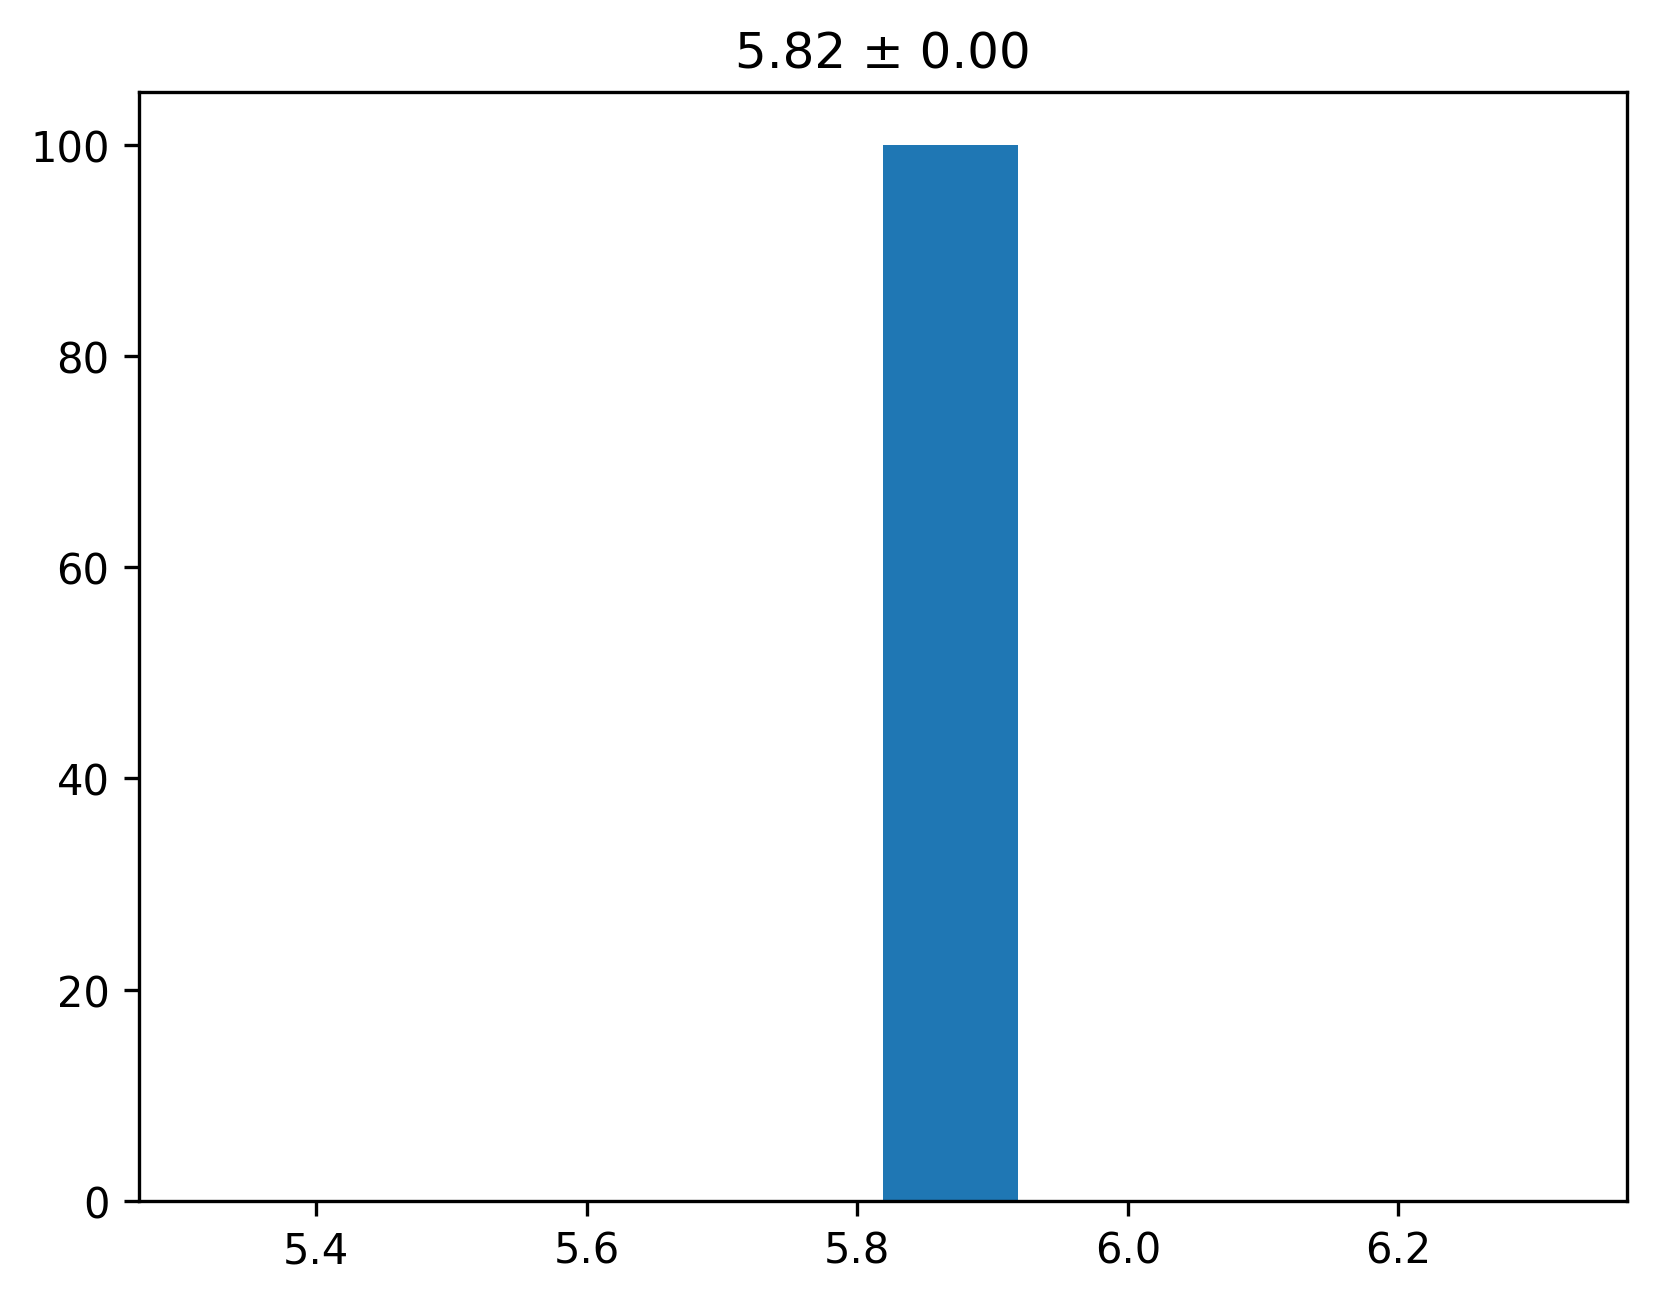

In [14]:
import matplotlib.pyplot as plt

x = jnp.array(scores)

plt.figure(dpi=300)
plt.title(f"{x.mean():.2f} ± {x.std():.2f}")
plt.hist(x)
plt.show()

# Make graph

In [20]:
deformations_included = jnp.array([0,2,3])
m = deformations_included.shape[0] # Number of diferent deformations per qubit
n = code.hx_original.shape[1] # Number of data qubits that can have deformations
all_deformations = jnp.zeros(shape=(m**n, n), dtype=jnp.int32) + jnp.arange(0, m**n)[:, None]
all_deformations = (all_deformations // m**jnp.arange(0, n)) % m
all_deformations = deformations_included[all_deformations]
print(all_deformations.shape)
print(all_deformations)

(19683, 9)
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [0 3 3 ... 3 3 3]
 [2 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


In [27]:
from jax import vmap
from time import time
t0 = time()

all_logical_error_rates = jnp.zeros(all_deformations.shape[0])
batch_size = m**3
for i, deformations_batch in enumerate(all_deformations.reshape((-1, batch_size, n))):
    all_logical_error_rates = all_logical_error_rates.at[i*batch_size:(i+1)*batch_size].set(
        vmap(env._score_state, in_axes=(None, 0))(key, deformations_batch)[0]
    )
    procentage = (i+1) / (all_deformations.shape[0] // batch_size)
    remaining_time = (time()-t0) / procentage * (1 - procentage)
    print(f"{int(remaining_time/60/60):5d}h {int(remaining_time/60%60):02d}m {int(remaining_time%60):02d}s    ({procentage:.2%})"+10*" ", end='\r')

In [ ]:
# jnp.save("environmentPML_scores_p01_nu500_halve.npy", all_logical_error_rates)

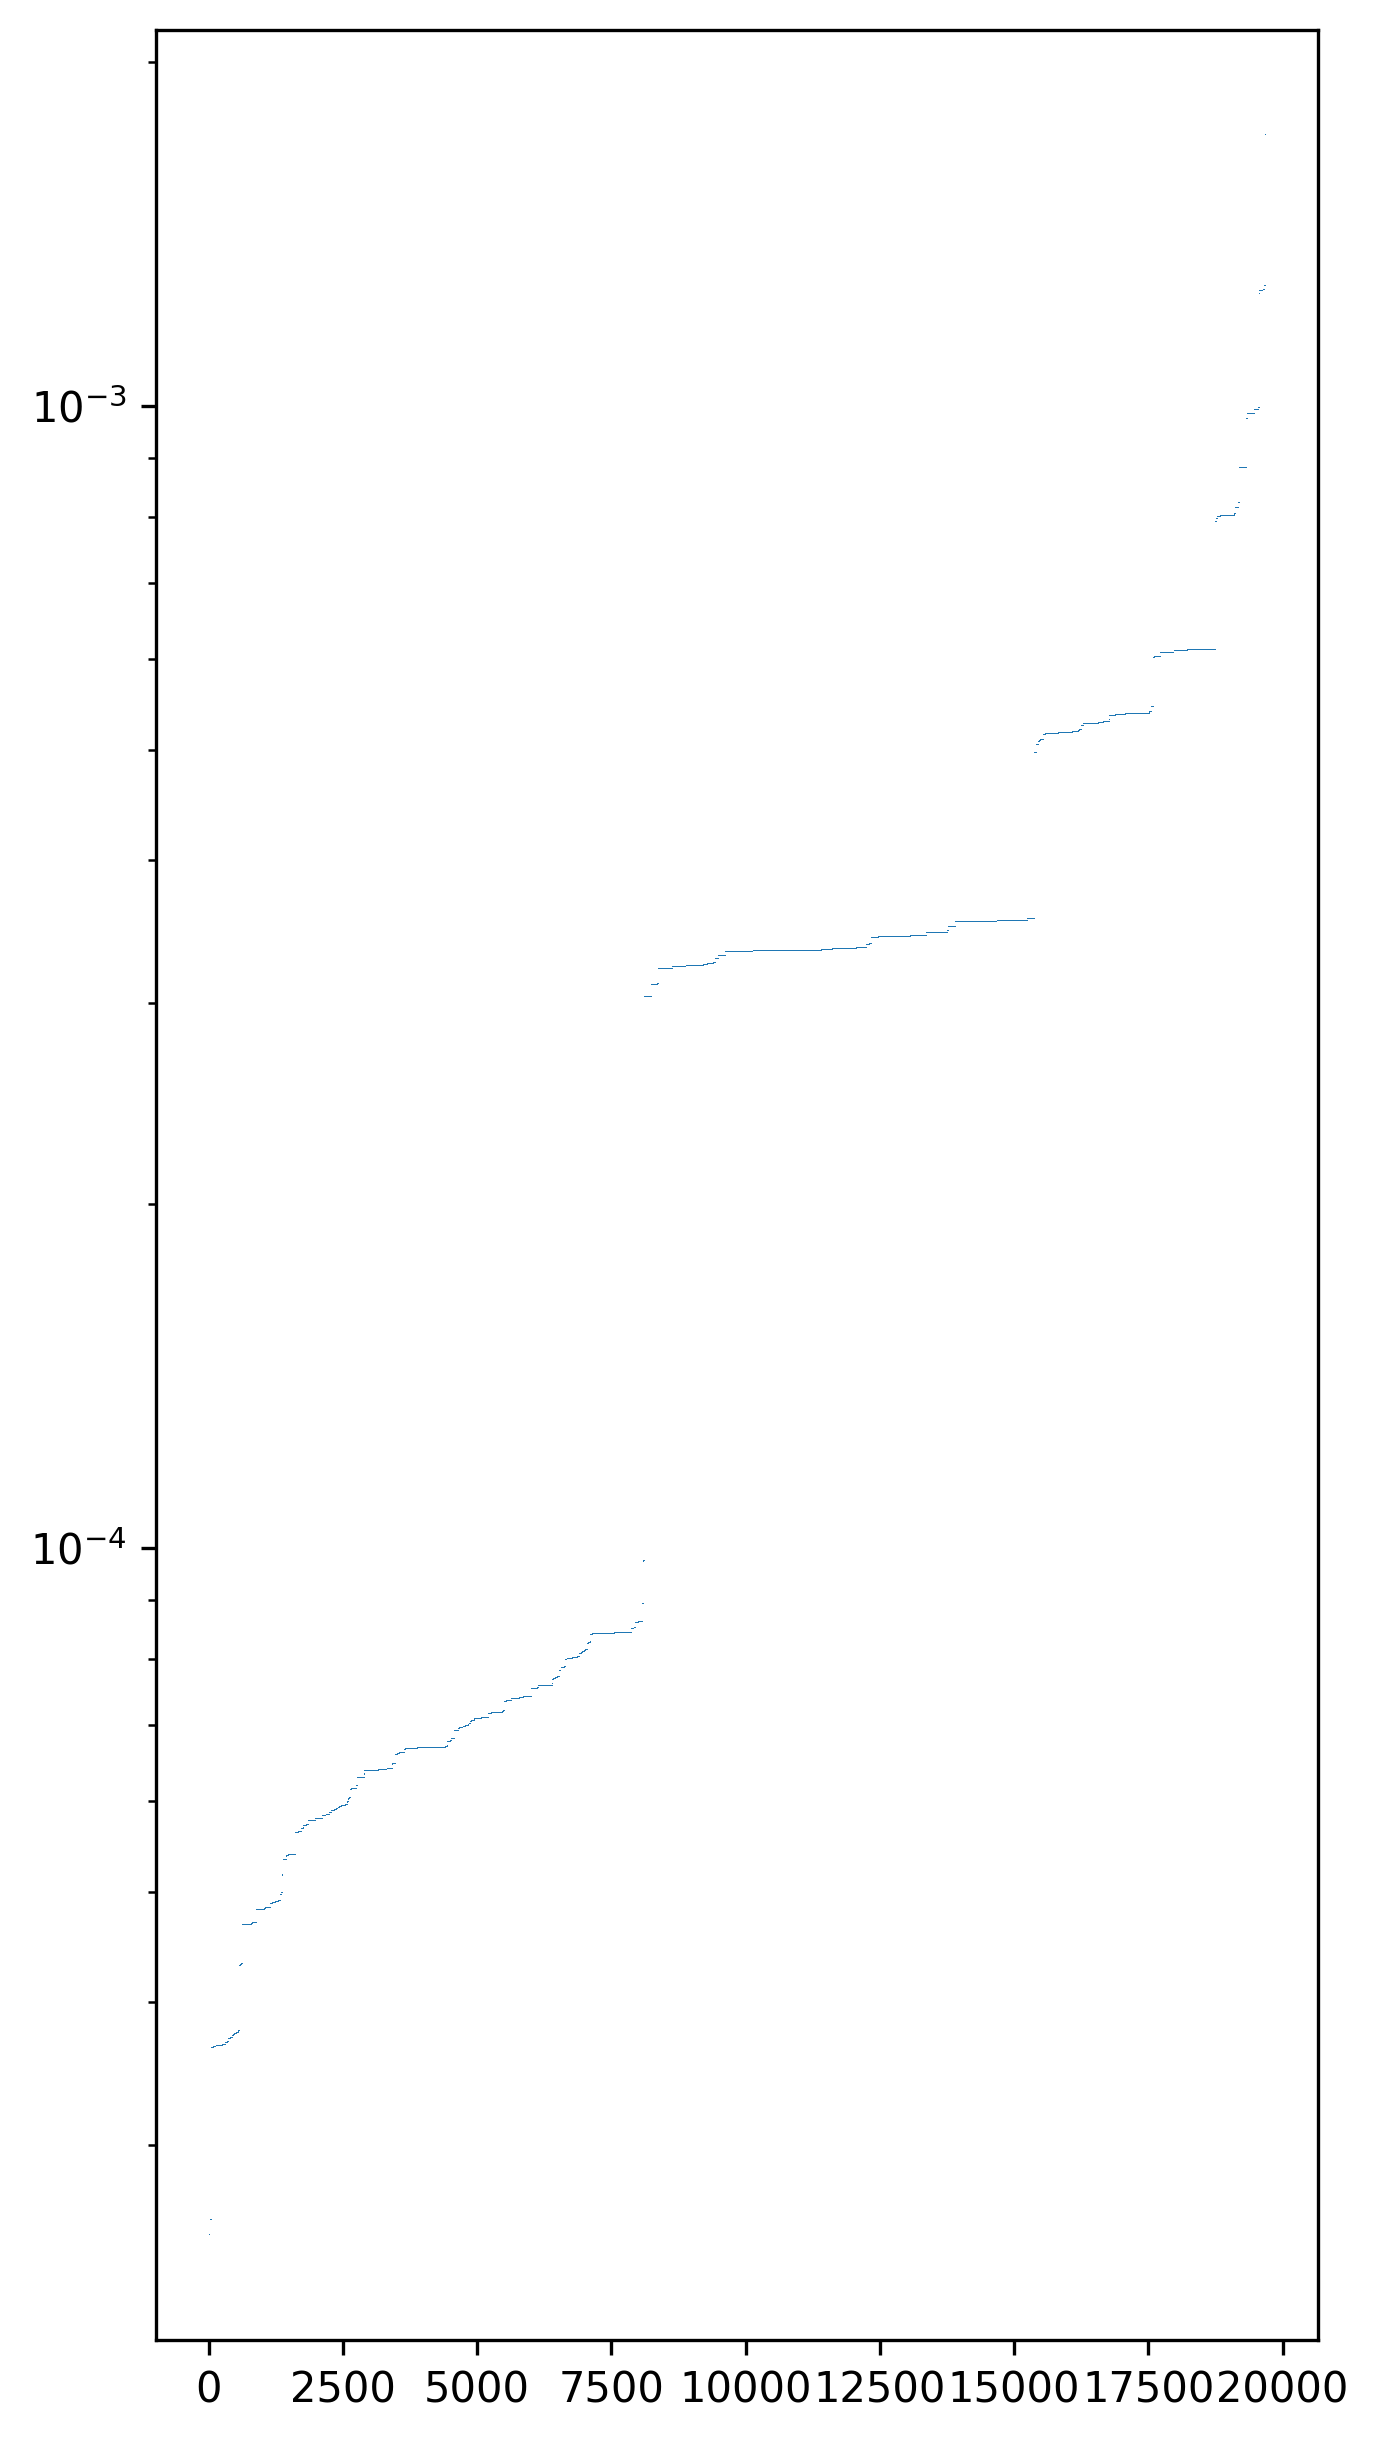

In [17]:
plt.figure(dpi=300, figsize=(5,10))
plt.plot((-jnp.log(.99) / all_logical_error_rates).sort(), ',')
plt.yscale('log')
plt.show()